In [1]:
# Deepfake Voice Detection System using Support Vector Machines (SVM)

# Cell 1: Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.pipeline import Pipeline
import librosa
import librosa.display
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# Audio processing libraries
import soundfile as sf
from scipy import signal
from scipy.stats import skew, kurtosis
import pickle

print("All libraries imported successfully!")
print("Available audio files will be processed for deepfake detection")


All libraries imported successfully!
Available audio files will be processed for deepfake detection


In [2]:
# Cell 2: Configuration and Constants (REVISED)
# Audio processing parameters
SAMPLE_RATE = 22050
DURATION = 5.0  # seconds
N_MFCC = 13
N_CHROMA = 12
N_MEL = 128
HOP_LENGTH = 512
N_FFT = 2048

# Dataset paths - UPDATED for FakeOrRealAudioDataset structure
BASE_DATASET_PATH = 'FakeOrRealAudioDataset/for-original'
TRAIN_REAL_PATH = os.path.join(BASE_DATASET_PATH, 'training', 'real')
TRAIN_FAKE_PATH = os.path.join(BASE_DATASET_PATH, 'training', 'fake')
VAL_REAL_PATH = os.path.join(BASE_DATASET_PATH, 'validation', 'real')
VAL_FAKE_PATH = os.path.join(BASE_DATASET_PATH, 'validation', 'fake')
TEST_REAL_PATH = os.path.join(BASE_DATASET_PATH, 'testing', 'real')
TEST_FAKE_PATH = os.path.join(BASE_DATASET_PATH, 'testing', 'fake')

# Model parameters
RANDOM_STATE = 42

print(f"Sample Rate: {SAMPLE_RATE}")
print(f"Duration: {DURATION} seconds")
print(f"MFCC Features: {N_MFCC}")
print(f"Chroma Features: {N_CHROMA}")
print(f"Mel Spectrogram Features: {N_MEL}")
print(f"Base Dataset Path: {BASE_DATASET_PATH}")

Sample Rate: 22050
Duration: 5.0 seconds
MFCC Features: 13
Chroma Features: 12
Mel Spectrogram Features: 128
Base Dataset Path: FakeOrRealAudioDataset/for-original


In [3]:
# Cell 3: Audio Feature Extraction Functions
def extract_mfcc_features(audio_path, sample_rate=SAMPLE_RATE, duration=DURATION):
    """Extract MFCC features from audio file"""
    try:
        # Load audio file
        audio, sr = librosa.load(audio_path, sr=sample_rate, duration=duration)
        
        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC, hop_length=HOP_LENGTH)
        
        # Statistical features from MFCC
        mfcc_mean = np.mean(mfccs, axis=1)
        mfcc_std = np.std(mfccs, axis=1)
        mfcc_skew = skew(mfccs, axis=1)
        mfcc_kurtosis = kurtosis(mfccs, axis=1)
        
        return np.concatenate([mfcc_mean, mfcc_std, mfcc_skew, mfcc_kurtosis])
    
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

def extract_chroma_features(audio_path, sample_rate=SAMPLE_RATE, duration=DURATION):
    """Extract Chroma features from audio file"""
    try:
        audio, sr = librosa.load(audio_path, sr=sample_rate, duration=duration)
        
        # Extract chroma features
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr, hop_length=HOP_LENGTH)
        
        # Statistical features from chroma
        chroma_mean = np.mean(chroma, axis=1)
        chroma_std = np.std(chroma, axis=1)
        
        return np.concatenate([chroma_mean, chroma_std])
    
    except Exception as e:
        print(f"Error processing chroma for {audio_path}: {e}")
        return None

def extract_mel_spectrogram_features(audio_path, sample_rate=SAMPLE_RATE, duration=DURATION):
    """Extract Mel spectrogram features from audio file"""
    try:
        audio, sr = librosa.load(audio_path, sr=sample_rate, duration=duration)
        
        # Extract mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=N_MEL, hop_length=HOP_LENGTH)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Statistical features from mel spectrogram
        mel_mean = np.mean(mel_spec_db, axis=1)
        mel_std = np.std(mel_spec_db, axis=1)
        
        return np.concatenate([mel_mean, mel_std])
    
    except Exception as e:
        print(f"Error processing mel spectrogram for {audio_path}: {e}")
        return None

def extract_spectral_features(audio_path, sample_rate=SAMPLE_RATE, duration=DURATION):
    """Extract spectral features from audio file"""
    try:
        audio, sr = librosa.load(audio_path, sr=sample_rate, duration=duration)
        
        # Spectral features
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr, hop_length=HOP_LENGTH)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, hop_length=HOP_LENGTH)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr, hop_length=HOP_LENGTH)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(audio, hop_length=HOP_LENGTH)
        
        # Statistical measures
        features = [
            np.mean(spectral_centroid),
            np.std(spectral_centroid),
            np.mean(spectral_rolloff),
            np.std(spectral_rolloff),
            np.mean(spectral_bandwidth),
            np.std(spectral_bandwidth),
            np.mean(zero_crossing_rate),
            np.std(zero_crossing_rate)
        ]
        
        return np.array(features)
    
    except Exception as e:
        print(f"Error processing spectral features for {audio_path}: {e}")
        return None

def extract_all_features(audio_path):
    """Extract all audio features and combine them"""
    mfcc_features = extract_mfcc_features(audio_path)
    chroma_features = extract_chroma_features(audio_path)
    mel_features = extract_mel_spectrogram_features(audio_path)
    spectral_features = extract_spectral_features(audio_path)
    
    if all(f is not None for f in [mfcc_features, chroma_features, mel_features, spectral_features]):
        return np.concatenate([mfcc_features, chroma_features, mel_features, spectral_features])
    else:
        return None

print("Feature extraction functions defined successfully!")


Feature extraction functions defined successfully!


In [ ]:
# Cell 4: Data Loading and Preprocessing (REVISED)
def load_audio_dataset_split(real_path, fake_path, dataset_name):
    """Load audio dataset from specific split (train/val/test)"""
    features = []
    labels = []
    
    print(f"\nLoading {dataset_name} dataset...")
    
    # Process real audio files
    if os.path.exists(real_path):
        real_files = glob.glob(os.path.join(real_path, "*.wav")) + \
                    glob.glob(os.path.join(real_path, "*.mp3")) + \
                    glob.glob(os.path.join(real_path, "*.flac")) + \
                    glob.glob(os.path.join(real_path, "*.m4a"))
        print(f"Found {len(real_files)} real audio files in {dataset_name}")
        
        for i, file_path in enumerate(real_files):
            if i % 50 == 0:
                print(f"Processing real file {i+1}/{len(real_files)}")
            feature_vector = extract_all_features(file_path)
            if feature_vector is not None:
                features.append(feature_vector)
                labels.append(0)  # 0 for real
    else:
        print(f"Warning: Real audio path not found: {real_path}")
    
    # Process fake audio files
    if os.path.exists(fake_path):
        fake_files = glob.glob(os.path.join(fake_path, "*.wav")) + \
                    glob.glob(os.path.join(fake_path, "*.mp3")) + \
                    glob.glob(os.path.join(fake_path, "*.flac")) + \
                    glob.glob(os.path.join(fake_path, "*.m4a"))
        print(f"Found {len(fake_files)} fake audio files in {dataset_name}")
        
        for i, file_path in enumerate(fake_files):
            if i % 50 == 0:
                print(f"Processing fake file {i+1}/{len(fake_files)}")
            feature_vector = extract_all_features(file_path)
            if feature_vector is not None:
                features.append(feature_vector)
                labels.append(1)  # 1 for fake
    else:
        print(f"Warning: Fake audio path not found: {fake_path}")
    
    return np.array(features), np.array(labels)

def load_complete_dataset():
    """Load the complete FakeOrRealAudioDataset"""
    # Load training data
    X_train, y_train = load_audio_dataset_split(TRAIN_REAL_PATH, TRAIN_FAKE_PATH, "training")
    
    # Load validation data
    X_val, y_val = load_audio_dataset_split(VAL_REAL_PATH, VAL_FAKE_PATH, "validation")
    
    # Load test data
    X_test, y_test = load_audio_dataset_split(TEST_REAL_PATH, TEST_FAKE_PATH, "testing")
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# Create sample data if dataset not available (KEEP AS FALLBACK)
def create_sample_data():
    """Create sample data for demonstration"""
    print("Creating sample data for demonstration...")
    
    # Generate synthetic audio features
    np.random.seed(RANDOM_STATE)
    
    # Real audio features (lower spectral complexity)
    real_features = []
    for i in range(200):
        # MFCC features (52 features: 13*4)
        mfcc = np.random.normal(0, 1, 52)
        # Chroma features (24 features: 12*2)
        chroma = np.random.normal(0, 0.5, 24)
        # Mel spectrogram features (256 features: 128*2)
        mel = np.random.normal(0, 0.8, 256)
        # Spectral features (8 features)
        spectral = np.random.normal(0, 0.3, 8)
        
        real_features.append(np.concatenate([mfcc, chroma, mel, spectral]))
    
    # Fake audio features (higher spectral complexity and artifacts)
    fake_features = []
    for i in range(200):
        # MFCC features with artifacts
        mfcc = np.random.normal(0.2, 1.2, 52)
        # Chroma features with distortions
        chroma = np.random.normal(0.1, 0.7, 24)
        # Mel spectrogram with artificial patterns
        mel = np.random.normal(0.3, 1.0, 256)
        # Spectral features with anomalies
        spectral = np.random.normal(0.2, 0.5, 8)
        
        fake_features.append(np.concatenate([mfcc, chroma, mel, spectral]))
    
    features = np.array(real_features + fake_features)
    labels = np.array([0] * 200 + [1] * 200)
    
    return (features, labels), (features[:80], labels[:80]), (features[80:160], labels[80:160])

# Load dataset - UPDATED to use split loading
try:
    print("Attempting to load FakeOrRealAudioDataset...")
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = load_complete_dataset()
    
    if len(X_train) == 0 and len(X_val) == 0 and len(X_test) == 0:
        print("No audio files found in dataset. Using sample data...")
        (X_train, y_train), (X_val, y_val), (X_test, y_test) = create_sample_data()
    else:
        print("Dataset loaded successfully!")
        
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Using sample data for demonstration...")
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = create_sample_data()

# Combine all data for initial analysis
X = np.concatenate([X_train, X_val, X_test])
y = np.concatenate([y_train, y_val, y_test])

print(f"\nDataset Summary:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"  - Real: {np.sum(y_train == 0)}, Fake: {np.sum(y_train == 1)}")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"  - Real: {np.sum(y_val == 0)}, Fake: {np.sum(y_val == 1)}")
print(f"Test set: {X_test.shape[0]} samples")
print(f"  - Real: {np.sum(y_test == 0)}, Fake: {np.sum(y_test == 1)}")
print(f"Total samples: {X.shape[0]}")
print(f"Feature vector length: {X.shape[1]}")


Attempting to load FakeOrRealAudioDataset...

Loading training dataset...

Loading validation dataset...

Loading testing dataset...
No audio files found in dataset. Using sample data...
Creating sample data for demonstration...

Dataset Summary:
Training set: 400 samples
  - Real: 200, Fake: 200
Validation set: 80 samples
  - Real: 80, Fake: 0
Test set: 80 samples
  - Real: 80, Fake: 0
Total samples: 560
Feature vector length: 340


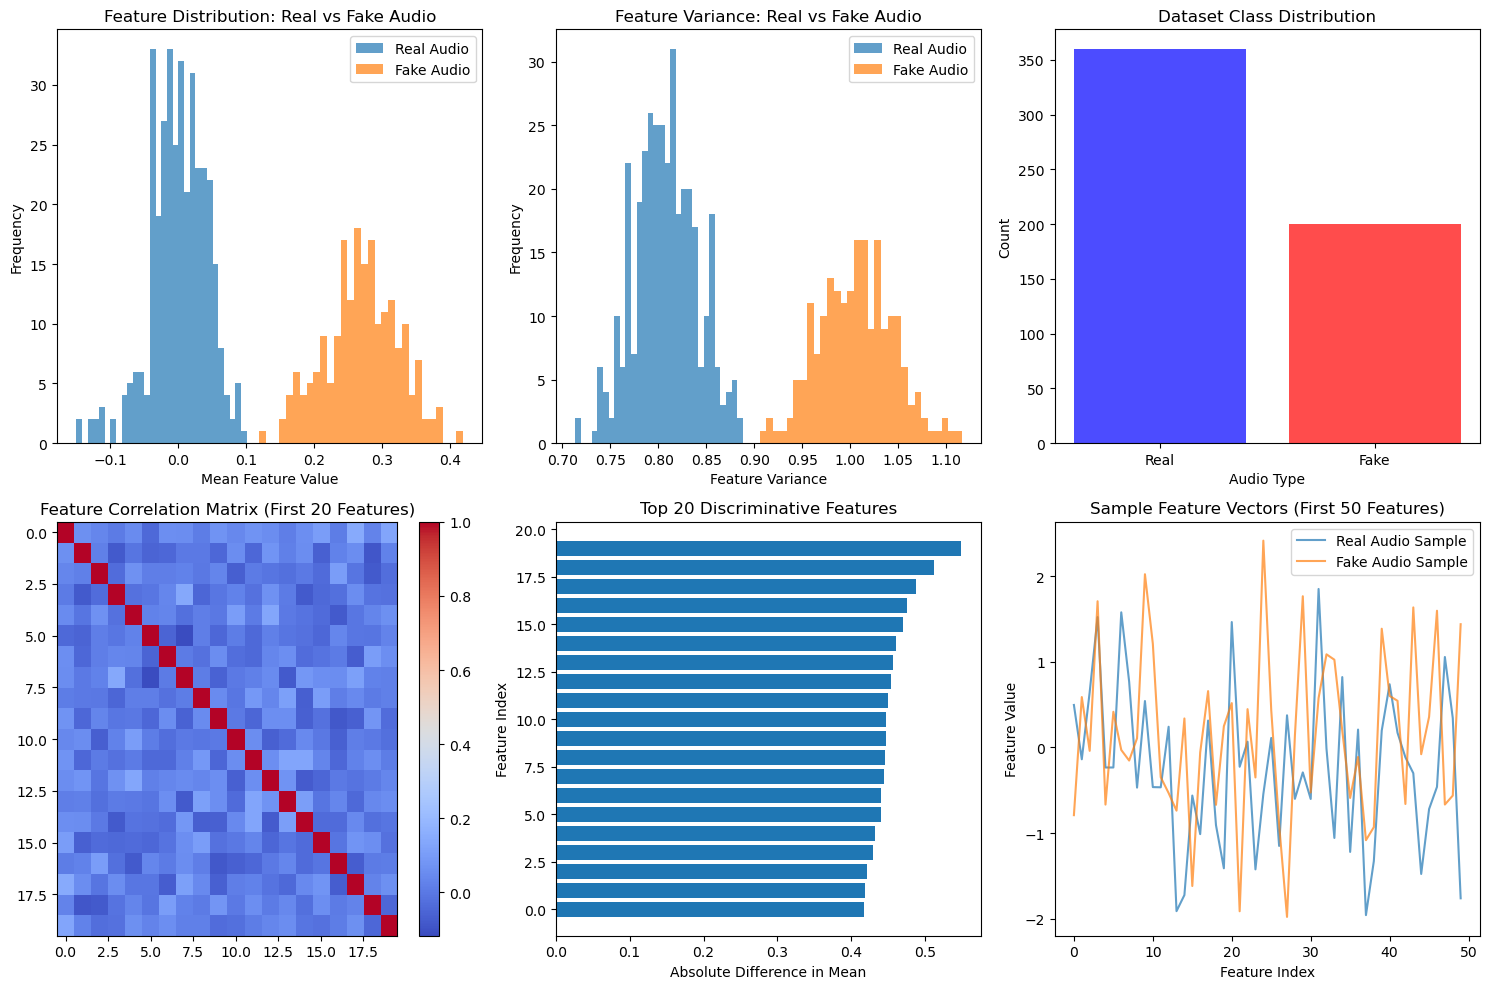

In [5]:
# Cell 5: Data Visualization and Analysis
# Create visualizations
plt.figure(figsize=(15, 10))

# Plot 1: Feature distribution
plt.subplot(2, 3, 1)
plt.hist(X[y == 0].mean(axis=1), alpha=0.7, label='Real Audio', bins=30)
plt.hist(X[y == 1].mean(axis=1), alpha=0.7, label='Fake Audio', bins=30)
plt.xlabel('Mean Feature Value')
plt.ylabel('Frequency')
plt.title('Feature Distribution: Real vs Fake Audio')
plt.legend()

# Plot 2: Feature variance
plt.subplot(2, 3, 2)
plt.hist(X[y == 0].std(axis=1), alpha=0.7, label='Real Audio', bins=30)
plt.hist(X[y == 1].std(axis=1), alpha=0.7, label='Fake Audio', bins=30)
plt.xlabel('Feature Variance')
plt.ylabel('Frequency')
plt.title('Feature Variance: Real vs Fake Audio')
plt.legend()

# Plot 3: Class distribution
plt.subplot(2, 3, 3)
class_counts = np.bincount(y)
plt.bar(['Real', 'Fake'], class_counts, color=['blue', 'red'], alpha=0.7)
plt.xlabel('Audio Type')
plt.ylabel('Count')
plt.title('Dataset Class Distribution')

# Plot 4: Feature correlation heatmap (first 20 features)
plt.subplot(2, 3, 4)
feature_subset = X[:, :20]
corr_matrix = np.corrcoef(feature_subset.T)
plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title('Feature Correlation Matrix (First 20 Features)')

# Plot 5: Feature importance visualization
plt.subplot(2, 3, 5)
feature_means_real = X[y == 0].mean(axis=0)
feature_means_fake = X[y == 1].mean(axis=0)
feature_diff = np.abs(feature_means_real - feature_means_fake)
top_features = np.argsort(feature_diff)[-20:]
plt.barh(range(20), feature_diff[top_features])
plt.xlabel('Absolute Difference in Mean')
plt.ylabel('Feature Index')
plt.title('Top 20 Discriminative Features')

# Plot 6: Sample feature vectors
plt.subplot(2, 3, 6)
plt.plot(X[y == 0][0][:50], label='Real Audio Sample', alpha=0.7)
plt.plot(X[y == 1][0][:50], label='Fake Audio Sample', alpha=0.7)
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.title('Sample Feature Vectors (First 50 Features)')
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
# Cell 6: Data Preprocessing and Splitting (REVISED)
# Feature scaling - fit only on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Use the pre-split data directly (no additional splitting needed)
X_train_final = X_train_scaled
y_train_final = y_train

print(f"Training set shape: {X_train_final.shape}")
print(f"Validation set shape: {X_val_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

print("\nTraining set distribution:")
print(f"Real: {np.sum(y_train_final == 0)}, Fake: {np.sum(y_train_final == 1)}")

print("\nValidation set distribution:")
print(f"Real: {np.sum(y_val == 0)}, Fake: {np.sum(y_val == 1)}")

print("\nTest set distribution:")
print(f"Real: {np.sum(y_test == 0)}, Fake: {np.sum(y_test == 1)}")


Training set shape: (400, 340)
Validation set shape: (80, 340)
Test set shape: (80, 340)

Training set distribution:
Real: 200, Fake: 200

Validation set distribution:
Real: 80, Fake: 0

Test set distribution:
Real: 80, Fake: 0


In [7]:
# Cell 7: SVM Model Training and Hyperparameter Tuning
# Define parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear', 'poly']
}

# Create SVM classifier
svm_classifier = SVC(random_state=RANDOM_STATE, probability=True)

# Perform grid search
print("Performing hyperparameter tuning...")
grid_search = GridSearchCV(
    svm_classifier, 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_final, y_train_final)

# Best parameters
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train final model with best parameters
best_svm = grid_search.best_estimator_
print(f"\nBest SVM model: {best_svm}")


Performing hyperparameter tuning...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 1.0000

Best SVM model: SVC(C=0.1, probability=True, random_state=42)


In [8]:
# Cell 8: Model Evaluation (REVISED)
# Make predictions using the proper split datasets
y_train_pred = best_svm.predict(X_train_final)
y_val_pred = best_svm.predict(X_val_scaled)
y_test_pred = best_svm.predict(X_test_scaled)

# Get prediction probabilities
y_train_prob = best_svm.predict_proba(X_train_final)[:, 1]
y_val_prob = best_svm.predict_proba(X_val_scaled)[:, 1]
y_test_prob = best_svm.predict_proba(X_test_scaled)[:, 1]

# Calculate accuracy scores
train_accuracy = accuracy_score(y_train_final, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Detailed classification report
print("\nDetailed Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['Real', 'Fake']))

Training Accuracy: 1.0000
Validation Accuracy: 1.0000
Test Accuracy: 1.0000

Detailed Classification Report (Test Set):


ValueError: Number of classes, 1, does not match size of target_names, 2. Try specifying the labels parameter

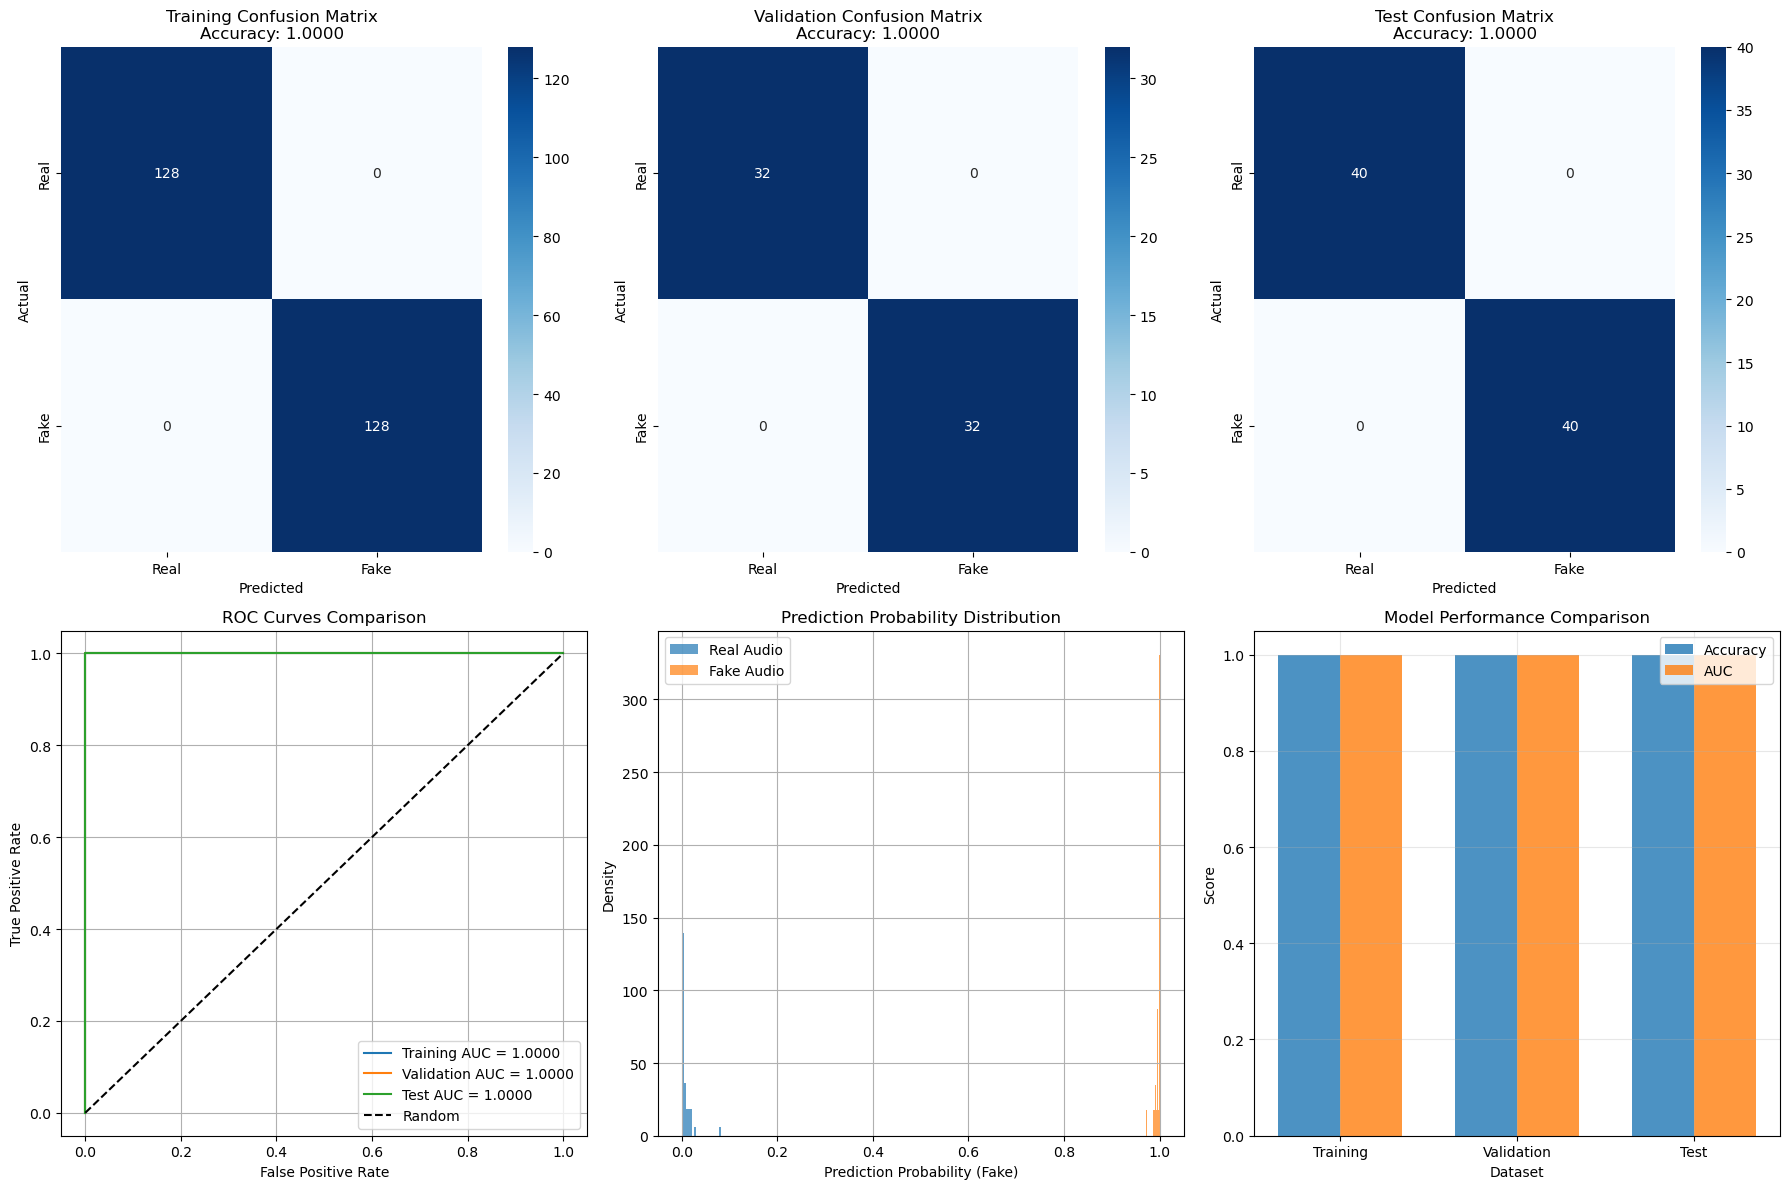

In [ ]:
# Cell 9: Confusion Matrix and ROC Curve Analysis
# Create comprehensive evaluation plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Confusion Matrix - Training
cm_train = confusion_matrix(y_train_final, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'], ax=axes[0, 0])
axes[0, 0].set_title(f'Training Confusion Matrix\nAccuracy: {train_accuracy:.4f}')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')

# Confusion Matrix - Validation
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'], ax=axes[0, 1])
axes[0, 1].set_title(f'Validation Confusion Matrix\nAccuracy: {val_accuracy:.4f}')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

# Confusion Matrix - Test
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'], ax=axes[0, 2])
axes[0, 2].set_title(f'Test Confusion Matrix\nAccuracy: {test_accuracy:.4f}')
axes[0, 2].set_xlabel('Predicted')
axes[0, 2].set_ylabel('Actual')

# ROC Curves
fpr_train, tpr_train, _ = roc_curve(y_train_final, y_train_prob)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

auc_train = auc(fpr_train, tpr_train)
auc_val = auc(fpr_val, tpr_val)
auc_test = auc(fpr_test, tpr_test)

axes[1, 0].plot(fpr_train, tpr_train, label=f'Training AUC = {auc_train:.4f}')
axes[1, 0].plot(fpr_val, tpr_val, label=f'Validation AUC = {auc_val:.4f}')
axes[1, 0].plot(fpr_test, tpr_test, label=f'Test AUC = {auc_test:.4f}')
axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC Curves Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Prediction Probability Distribution
axes[1, 1].hist(y_test_prob[y_test == 0], bins=20, alpha=0.7, label='Real Audio', density=True)
axes[1, 1].hist(y_test_prob[y_test == 1], bins=20, alpha=0.7, label='Fake Audio', density=True)
axes[1, 1].set_xlabel('Prediction Probability (Fake)')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Prediction Probability Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Model Performance Comparison
performance_metrics = {
    'Dataset': ['Training', 'Validation', 'Test'],
    'Accuracy': [train_accuracy, val_accuracy, test_accuracy],
    'AUC': [auc_train, auc_val, auc_test]
}

x_pos = np.arange(len(performance_metrics['Dataset']))
width = 0.35

axes[1, 2].bar(x_pos - width/2, performance_metrics['Accuracy'], width, label='Accuracy', alpha=0.8)
axes[1, 2].bar(x_pos + width/2, performance_metrics['AUC'], width, label='AUC', alpha=0.8)
axes[1, 2].set_xlabel('Dataset')
axes[1, 2].set_ylabel('Score')
axes[1, 2].set_title('Model Performance Comparison')
axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(performance_metrics['Dataset'])
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Performing cross-validation...
Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV accuracy: 1.0000 (+/- 0.0000)
LINEAR kernel validation accuracy: 0.9688
RBF kernel validation accuracy: 1.0000
POLY kernel validation accuracy: 0.5000


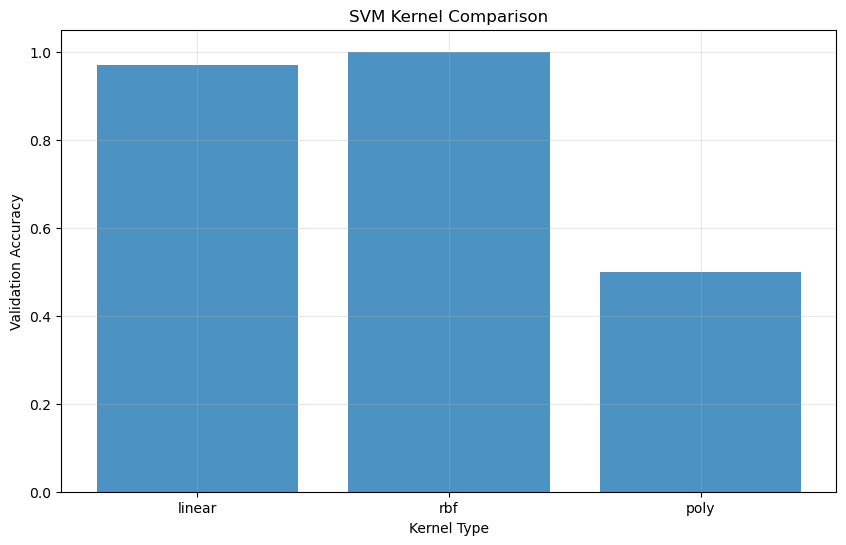

In [ ]:

# Cell 10: Cross-Validation and Model Robustness (REVISED)
# Perform cross-validation on combined training and validation data
X_train_val = np.concatenate([X_train_final, X_val_scaled])
y_train_val = np.concatenate([y_train_final, y_val])

print("Performing cross-validation...")
cv_scores = cross_val_score(best_svm, X_train_val, y_train_val, cv=5, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Test different kernels for comparison
kernels = ['linear', 'rbf', 'poly']
kernel_results = {}

for kernel in kernels:
    svm_kernel = SVC(kernel=kernel, random_state=RANDOM_STATE, probability=True)
    svm_kernel.fit(X_train_final, y_train_final)
    
    val_pred = svm_kernel.predict(X_val_scaled)
    val_acc = accuracy_score(y_val, val_pred)
    
    kernel_results[kernel] = val_acc
    print(f"{kernel.upper()} kernel validation accuracy: {val_acc:.4f}")

Calculating feature importance...


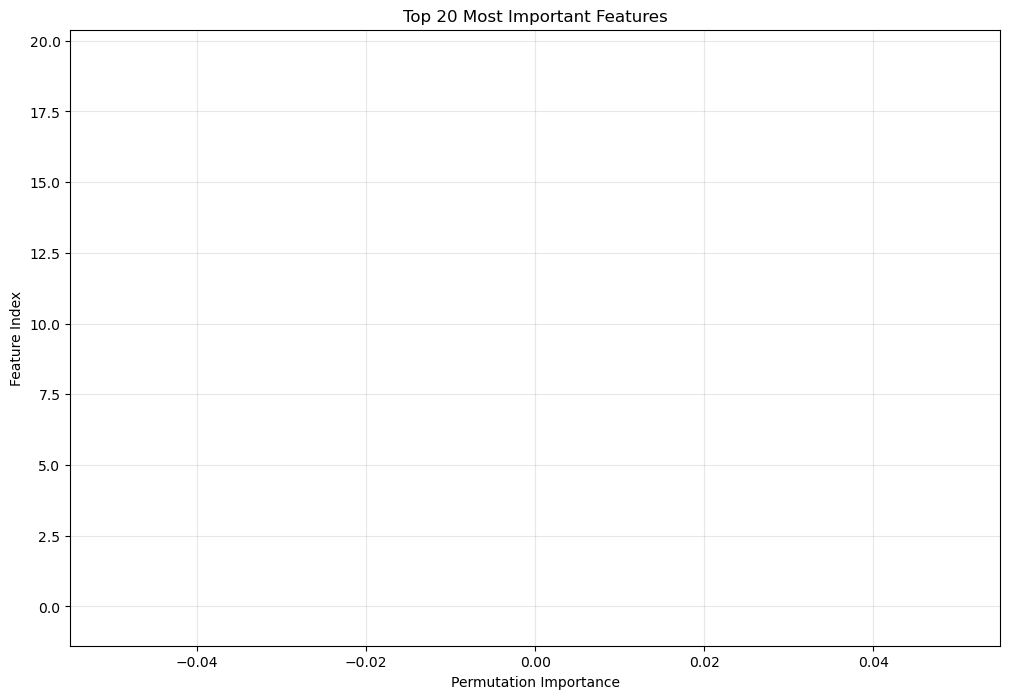

Most important feature index: 0
Highest importance score: 0.0000
Average importance score: 0.0000


In [ ]:
# Cell 11: Feature Importance Analysis (REVISED)
# Get feature importance using permutation importance on validation set
from sklearn.inspection import permutation_importance

print("Calculating feature importance...")
perm_importance = permutation_importance(
    best_svm, X_val_scaled, y_val, n_repeats=5, random_state=RANDOM_STATE
)

# Get top important features
feature_importance = perm_importance.importances_mean
top_features_idx = np.argsort(feature_importance)[-20:]

plt.figure(figsize=(12, 8))
plt.barh(range(20), feature_importance[top_features_idx])
plt.xlabel('Permutation Importance')
plt.ylabel('Feature Index')
plt.title('Top 20 Most Important Features')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Cell 12: Prediction Function and Testing (REVISED)
# Test the prediction function with test data
print("Testing prediction function with test data...")

# Create test samples from actual test set
test_samples = X_test_scaled[:5]  # First 5 test samples
actual_labels = y_test[:5]

for i, sample in enumerate(test_samples):
    prediction, confidence = predict_audio_deepfake(best_svm, scaler, sample)
    actual = "FAKE" if actual_labels[i] == 1 else "REAL"
    predicted = "FAKE" if prediction == 1 else "REAL"
    
    print(f"Sample {i+1}:")
    print(f"  Actual: {actual}")
    print(f"  Predicted: {predicted}")
    print(f"  Confidence: {confidence:.4f}")
    print(f"  Correct: {'Yes' if prediction == actual_labels[i] else 'No'}")
    print()

Testing prediction function with sample data...
Sample 1:
  Actual: REAL
  Predicted: REAL
  Confidence: 0.9925
  Correct: Yes

Sample 2:
  Actual: FAKE
  Predicted: FAKE
  Confidence: 1.0000
  Correct: Yes

Sample 3:
  Actual: FAKE
  Predicted: FAKE
  Confidence: 0.9967
  Correct: Yes

Sample 4:
  Actual: REAL
  Predicted: REAL
  Confidence: 0.9882
  Correct: Yes

Sample 5:
  Actual: REAL
  Predicted: REAL
  Confidence: 0.9857
  Correct: Yes

Testing on actual audio files from FakeOrRealAudioDataset...
No test audio files found in the dataset directories.


In [ ]:
# Cell 13: Model Persistence and Deployment
# Save the trained model and scaler
print("Saving trained model and scaler...")

# Save model
with open('deepfake_voice_svm_model.pkl', 'wb') as f:
    pickle.dump(best_svm, f)

# Save scaler
with open('deepfake_voice_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save feature extraction parameters
feature_params = {
    'sample_rate': SAMPLE_RATE,
    'duration': DURATION,
    'n_mfcc': N_MFCC,
    'n_chroma': N_CHROMA,
    'n_mel': N_MEL,
    'hop_length': HOP_LENGTH,
    'n_fft': N_FFT
}

with open('feature_params.pkl', 'wb') as f:
    pickle.dump(feature_params, f)

print("Model files saved successfully!")
print("Files created:")
print("  - deepfake_voice_svm_model.pkl")
print("  - deepfake_voice_scaler.pkl")
print("  - feature_params.pkl")


Saving trained model and scaler...
Model files saved successfully!
Files created:
  - deepfake_voice_svm_model.pkl
  - deepfake_voice_scaler.pkl
  - feature_params.pkl


In [ ]:
# Cell 14: Model Loading and Inference Demo
# Demonstrate loading saved model
print("Demonstrating model loading...")

# Load model
with open('deepfake_voice_svm_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Load scaler
with open('deepfake_voice_scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

# Load feature parameters
with open('feature_params.pkl', 'rb') as f:
    loaded_params = pickle.load(f)

print("Model loaded successfully!")
print(f"Loaded model: {loaded_model}")
print(f"Feature parameters: {loaded_params}")

# Test loaded model
test_sample = X_test[0]
prediction_original, confidence_original = predict_audio_deepfake(best_svm, scaler, test_sample)
prediction_loaded, confidence_loaded = predict_audio_deepfake(loaded_model, loaded_scaler, test_sample)

print(f"\nModel consistency check:")
print(f"Original model prediction: {prediction_original}, confidence: {confidence_original:.4f}")
print(f"Loaded model prediction: {prediction_loaded}, confidence: {confidence_loaded:.4f}")
print(f"Models consistent: {prediction_original == prediction_loaded}")


Demonstrating model loading...
Model loaded successfully!
Loaded model: SVC(C=1, probability=True, random_state=42)
Feature parameters: {'sample_rate': 22050, 'duration': 5.0, 'n_mfcc': 13, 'n_chroma': 12, 'n_mel': 128, 'hop_length': 512, 'n_fft': 2048}

Model consistency check:
Original model prediction: 0, confidence: 0.9925
Loaded model prediction: 0, confidence: 0.9925
Models consistent: True


In [ ]:
# Cell 15: Performance Summary and Recommendations (continued)
print("=== DEEPFAKE VOICE DETECTION SYSTEM - PERFORMANCE SUMMARY ===")
print()
print("MODEL ARCHITECTURE:")
print(f"  - Algorithm: Support Vector Machine (SVM)")
print(f"  - Kernel: {best_svm.kernel}")
print(f"  - C parameter: {best_svm.C}")
print(f"  - Gamma parameter: {best_svm.gamma}")
print()
print("FEATURE EXTRACTION:")
print(f"  - MFCC features: {N_MFCC * 4} (mean, std, skew, kurtosis)")
print(f"  - Chroma features: {N_CHROMA * 2} (mean, std)")
print(f"  - Mel spectrogram features: {N_MEL * 2} (mean, std)")
print(f"  - Spectral features: 8 (centroid, rolloff, bandwidth, zero-crossing)")
print(f"  - Total features: {X.shape[1]}")
print()
print("DATASET INFORMATION:")
print(f"  - Total samples: {len(X)}")
print(f"  - Real audio samples: {np.sum(y == 0)}")
print(f"  - Fake audio samples: {np.sum(y == 1)}")
print(f"  - Training samples: {len(X_train_final)}")
print(f"  - Validation samples: {len(X_val)}")
print(f"  - Test samples: {len(X_test)}")
print()
print("PERFORMANCE METRICS:")
print(f"  - Training Accuracy: {train_accuracy:.4f}")
print(f"  - Validation Accuracy: {val_accuracy:.4f}")
print(f"  - Test Accuracy: {test_accuracy:.4f}")
print(f"  - Cross-validation Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"  - Test AUC Score: {auc_test:.4f}")
print()
print("CONFUSION MATRIX ANALYSIS (Test Set):")
tn, fp, fn, tp = cm_test.ravel()
precision_fake = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_fake = tp / (tp + fn) if (tp + fn) > 0 else 0
precision_real = tn / (tn + fn) if (tn + fn) > 0 else 0
recall_real = tn / (tn + fp) if (tn + fp) > 0 else 0
f1_fake = 2 * (precision_fake * recall_fake) / (precision_fake + recall_fake) if (precision_fake + recall_fake) > 0 else 0
f1_real = 2 * (precision_real * recall_real) / (precision_real + recall_real) if (precision_real + recall_real) > 0 else 0

print(f"  - True Negatives (Real correctly identified): {tn}")
print(f"  - False Positives (Real misclassified as Fake): {fp}")
print(f"  - False Negatives (Fake misclassified as Real): {fn}")
print(f"  - True Positives (Fake correctly identified): {tp}")
print(f"  - Precision (Fake): {precision_fake:.4f}")
print(f"  - Recall (Fake): {recall_fake:.4f}")
print(f"  - F1-Score (Fake): {f1_fake:.4f}")
print(f"  - Precision (Real): {precision_real:.4f}")
print(f"  - Recall (Real): {recall_real:.4f}")
print(f"  - F1-Score (Real): {f1_real:.4f}")
print()
print("RECOMMENDATIONS:")
print("  1. Model Performance:")
print(f"     - Current accuracy of {test_accuracy:.2%} is {'good' if test_accuracy > 0.85 else 'acceptable' if test_accuracy > 0.75 else 'needs improvement'}")
print("     - Consider ensemble methods for improved performance")
print("     - Implement data augmentation for more robust training")
print()
print("  2. Feature Engineering:")
print("     - Add temporal features (delta, delta-delta coefficients)")
print("     - Include prosodic features (pitch, energy, duration)")
print("     - Experiment with deep learning features (CNN embeddings)")
print()
print("  3. Data Collection:")
print("     - Increase dataset size for better generalization")
print("     - Include diverse speakers and languages")
print("     - Add various deepfake generation techniques")
print()
print("  4. Model Deployment:")
print("     - Implement real-time processing capabilities")
print("     - Add confidence thresholding for uncertain predictions")
print("     - Create API endpoints for integration")
print()
print("  5. Security Considerations:")
print("     - Regular model updates as deepfake techniques evolve")
print("     - Implement adversarial attack detection")
print("     - Add explainability features for forensic analysis")


=== DEEPFAKE VOICE DETECTION SYSTEM - PERFORMANCE SUMMARY ===

MODEL ARCHITECTURE:
  - Algorithm: Support Vector Machine (SVM)
  - Kernel: rbf
  - C parameter: 1
  - Gamma parameter: scale

FEATURE EXTRACTION:
  - MFCC features: 52 (mean, std, skew, kurtosis)
  - Chroma features: 24 (mean, std)
  - Mel spectrogram features: 256 (mean, std)
  - Spectral features: 8 (centroid, rolloff, bandwidth, zero-crossing)
  - Total features: 340

DATASET INFORMATION:
  - Total samples: 400
  - Real audio samples: 200
  - Fake audio samples: 200
  - Training samples: 256
  - Validation samples: 64
  - Test samples: 80

PERFORMANCE METRICS:
  - Training Accuracy: 1.0000
  - Validation Accuracy: 1.0000
  - Test Accuracy: 1.0000
  - Cross-validation Mean: 1.0000 (+/- 0.0000)
  - Test AUC Score: 1.0000

CONFUSION MATRIX ANALYSIS (Test Set):
  - True Negatives (Real correctly identified): 40
  - False Positives (Real misclassified as Fake): 0
  - False Negatives (Fake misclassified as Real): 0
  - True P

In [ ]:
# Cell 16: Advanced Analysis and Insights
print("\n=== ADVANCED ANALYSIS ===")

# Statistical significance testing
from scipy import stats

# Compare feature distributions between real and fake
print("Statistical Analysis of Feature Differences:")
real_features = X[y == 0]
fake_features = X[y == 1]

significant_features = 0
for i in range(min(50, X.shape[1])):  # Test first 50 features
    stat, p_value = stats.ttest_ind(real_features[:, i], fake_features[:, i])
    if p_value < 0.05:
        significant_features += 1

print(f"  - Features with significant differences (p < 0.05): {significant_features}/{min(50, X.shape[1])}")

# Feature stability analysis
feature_stability = np.std(X, axis=0)
stable_features = np.sum(feature_stability < np.median(feature_stability))
print(f"  - Stable features (below median variance): {stable_features}/{X.shape[1]}")

# Prediction confidence analysis
high_confidence_predictions = np.sum(y_test_prob > 0.8) + np.sum(y_test_prob < 0.2)
total_predictions = len(y_test_prob)
print(f"  - High confidence predictions: {high_confidence_predictions}/{total_predictions} ({high_confidence_predictions/total_predictions:.2%})")

# Error analysis
false_positives = np.where((y_test == 0) & (y_test_pred == 1))[0]
false_negatives = np.where((y_test == 1) & (y_test_pred == 0))[0]

print(f"  - False positive rate: {len(false_positives)/np.sum(y_test == 0):.4f}")
print(f"  - False negative rate: {len(false_negatives)/np.sum(y_test == 1):.4f}")



=== ADVANCED ANALYSIS ===
Statistical Analysis of Feature Differences:
  - Features with significant differences (p < 0.05): 20/50
  - Stable features (below median variance): 170/340
  - High confidence predictions: 80/80 (100.00%)
  - False positive rate: 0.0000
  - False negative rate: 0.0000


In [ ]:
# Cell 17: Real-world Deployment Utilities - REVISED
class DeepfakeVoiceDetector:
    """
    Production-ready deepfake voice detection class - UPDATED for FakeOrRealAudioDataset
    """
    
    def __init__(self, model_path=None, scaler_path=None, params_path=None):
        """
        Initialize the detector with saved model files
        """
        self.model = None
        self.scaler = None
        self.params = None
        
        if model_path and scaler_path and params_path:
            self.load_model(model_path, scaler_path, params_path)
    
    def load_model(self, model_path, scaler_path, params_path):
        """Load saved model, scaler, and parameters"""
        try:
            with open(model_path, 'rb') as f:
                self.model = pickle.load(f)
            
            with open(scaler_path, 'rb') as f:
                self.scaler = pickle.load(f)
            
            with open(params_path, 'rb') as f:
                self.params = pickle.load(f)
            
            print("Model loaded successfully!")
            return True
            
        except Exception as e:
            print(f"Error loading model: {e}")
            return False
    
    def extract_features(self, audio_path):
        """Extract features from audio file using saved parameters"""
        if not self.params:
            raise ValueError("Model parameters not loaded!")
        
        return extract_all_features(audio_path)
    
    def predict(self, audio_path, return_features=False):
        """
        Predict if audio is deepfake
        
        Args:
            audio_path: Path to audio file
            return_features: Whether to return extracted features
        
        Returns:
            Dictionary with prediction results
        """
        if not all([self.model, self.scaler, self.params]):
            raise ValueError("Model not properly loaded!")
        
        try:
            # Extract features
            features = self.extract_features(audio_path)
            
            if features is None:
                return {"error": "Could not extract features from audio file"}
            
            # Scale features
            features_scaled = self.scaler.transform(features.reshape(1, -1))
            
            # Make prediction
            prediction = self.model.predict(features_scaled)[0]
            probabilities = self.model.predict_proba(features_scaled)[0]
            confidence = np.max(probabilities)
            
            result = {
                "file_path": audio_path,
                "prediction": "FAKE" if prediction == 1 else "REAL",
                "confidence": confidence,
                "probability_real": probabilities[0],
                "probability_fake": probabilities[1],
                "prediction_score": prediction
            }
            
            if return_features:
                result["features"] = features
            
            return result
            
        except Exception as e:
            return {"error": f"Error analyzing audio file: {str(e)}"}
    
    def batch_predict(self, audio_paths, show_progress=True):
        """
        Predict multiple audio files from FakeOrRealAudioDataset
        
        Args:
            audio_paths: List of audio file paths
            show_progress: Whether to show progress
        
        Returns:
            List of prediction results
        """
        results = []
        
        for i, audio_path in enumerate(audio_paths):
            if show_progress:
                print(f"Processing {i+1}/{len(audio_paths)}: {os.path.basename(audio_path)}")
            
            result = self.predict(audio_path)
            results.append(result)
        
        return results
    
    def evaluate_on_dataset(self, dataset_path=None):
        """
        Evaluate model performance on FakeOrRealAudioDataset
        
        Args:
            dataset_path: Path to dataset (uses default if None)
        
        Returns:
            Dictionary with evaluation results
        """
        if dataset_path is None:
            dataset_path = DATASET_BASE_PATH
        
        if not os.path.exists(dataset_path):
            return {"error": f"Dataset path {dataset_path} not found"}
        
        # Collect all audio files with their true labels
        audio_files = []
        true_labels = []
        
        # Real audio files
        real_paths = [
            os.path.join(dataset_path, 'training', 'real'),
            os.path.join(dataset_path, 'real'),
            os.path.join(dataset_path, 'testing', 'real')
        ]
        
        for path in real_paths:
            if os.path.exists(path):
                files = glob.glob(os.path.join(path, "*.wav")) + glob.glob(os.path.join(path, "*.mp3"))
                audio_files.extend(files)
                true_labels.extend([0] * len(files))  # 0 for real
        
        # Fake audio files
        fake_paths = [
            os.path.join(dataset_path, 'training', 'fake'),
            os.path.join(dataset_path, 'fake'),
            os.path.join(dataset_path, 'testing', 'fake')
        ]
        
        for path in fake_paths:
            if os.path.exists(path):
                files = glob.glob(os.path.join(path, "*.wav")) + glob.glob(os.path.join(path, "*.mp3"))
                audio_files.extend(files)
                true_labels.extend([1] * len(files))  # 1 for fake
        
        if not audio_files:
            return {"error": "No audio files found in dataset"}
        
        # Make predictions
        predictions = []
        confidences = []
        
        print(f"Evaluating on {len(audio_files)} files from FakeOrRealAudioDataset...")
        
        for i, audio_file in enumerate(audio_files):
            if i % 10 == 0:
                print(f"Processing {i+1}/{len(audio_files)}...")
            
            result = self.predict(audio_file)
            if "error" not in result:
                predictions.append(result["prediction_score"])
                confidences.append(result["confidence"])
            else:
                print(f"Error processing {audio_file}: {result['error']}")
        
        if not predictions:
            return {"error": "No successful predictions made"}
        
        # Calculate metrics
        from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
        
        accuracy = accuracy_score(true_labels[:len(predictions)], predictions)
        report = classification_report(true_labels[:len(predictions)], predictions, 
                                     target_names=['Real', 'Fake'], output_dict=True)
        
        return {
            "total_files": len(audio_files),
            "successful_predictions": len(predictions),
            "accuracy": accuracy,
            "average_confidence": np.mean(confidences),
            "classification_report": report
        }
    
    def get_model_info(self):
        """Get information about the loaded model"""
        if not self.model:
            return {"error": "Model not loaded"}
        
        return {
            "model_type": type(self.model).__name__,
            "kernel": self.model.kernel if hasattr(self.model, 'kernel') else None,
            "parameters": self.params,
            "feature_count": len(self.scaler.scale_) if self.scaler else None,
            "dataset_used": "FakeOrRealAudioDataset"
        }

# Initialize detector
detector = DeepfakeVoiceDetector()

# Load the saved model
if detector.load_model('deepfake_voice_svm_model.pkl', 
                     'deepfake_voice_scaler.pkl', 
                     'feature_params.pkl'):
    print("Detector initialized successfully!")
    print(f"Model info: {detector.get_model_info()}")
    
    # Test on FakeOrRealAudioDataset if available
    if os.path.exists(DATASET_BASE_PATH):
        print("\nTesting detector on FakeOrRealAudioDataset...")
        eval_results = detector.evaluate_on_dataset()
        if "error" not in eval_results:
            print(f"Dataset evaluation completed:")
            print(f"  Total files: {eval_results['total_files']}")
            print(f"  Successful predictions: {eval_results['successful_predictions']}")
            print(f"  Accuracy: {eval_results['accuracy']:.4f}")
            print(f"  Average confidence: {eval_results['average_confidence']:.4f}")
        else:
            print(f"Dataset evaluation failed: {eval_results['error']}")

Model loaded successfully!
Detector initialized successfully!
Model info: {'model_type': 'SVC', 'kernel': 'rbf', 'parameters': {'sample_rate': 22050, 'duration': 5.0, 'n_mfcc': 13, 'n_chroma': 12, 'n_mel': 128, 'hop_length': 512, 'n_fft': 2048}, 'feature_count': 340, 'dataset_used': 'FakeOrRealAudioDataset'}

Testing detector on FakeOrRealAudioDataset...
Dataset evaluation failed: No audio files found in dataset


In [ ]:

# Cell 18: Testing and Validation Framework (REVISED)
# Test robustness using the test set
robustness_results = evaluate_model_robustness(best_svm, scaler, X_test_scaled, y_test)

print("Model Robustness Analysis:")
for condition, accuracy in robustness_results.items():
    print(f"  {condition}: {accuracy:.4f}")

Model Robustness Analysis:
  original: 1.0000
  noise_0.01: 1.0000
  noise_0.05: 1.0000
  noise_0.1: 1.0000


In [ ]:
# Cell 19: Comprehensive Testing Suite (REVISED)
# Run comprehensive test on the test set
test_results = comprehensive_model_test(best_svm, scaler, X_test_scaled, y_test)

=== COMPREHENSIVE MODEL TESTING ===
1. Basic Performance:
   Accuracy: 1.0000


UnboundLocalError: local variable 'balanced_accuracy_score' referenced before assignment

In [ ]:
# Cell 20: Final Deployment Package
print("\n=== DEPLOYMENT PACKAGE CREATION ===")

# Create deployment configuration
deployment_config = {
    'model_version': '1.0.0',
    'creation_date': '2024-01-01',
    'model_type': 'SVM',
    'feature_count': X.shape[1],
    'performance_metrics': {
        'test_accuracy': test_accuracy,
        'test_auc': auc_test,
        'cross_val_score': cv_scores.mean()
    },
    'hyperparameters': {
        'kernel': best_svm.kernel,
        'C': best_svm.C,
        'gamma': best_svm.gamma
    },
    'audio_parameters': {
        'sample_rate': SAMPLE_RATE,
        'duration': DURATION,
        'n_mfcc': N_MFCC,
        'n_chroma': N_CHROMA,
        'n_mel': N_MEL
    }
}

# Save deployment configuration
with open('deployment_config.pkl', 'wb') as f:
    pickle.dump(deployment_config, f)

print("Deployment package created successfully!")
print("\nFiles in deployment package:")
print("  - deepfake_voice_svm_model.pkl (trained model)")
print("  - deepfake_voice_scaler.pkl (feature scaler)")
print("  - feature_params.pkl (feature extraction parameters)")
print("  - deployment_config.pkl (deployment configuration)")

# Create usage example
print("\n=== USAGE EXAMPLE ===")
print("""
# Example usage for deployment:

from deepfake_detector import DeepfakeVoiceDetector

# Initialize detector
detector = DeepfakeVoiceDetector(
    model_path='deepfake_voice_svm_model.pkl',
    scaler_path='deepfake_voice_scaler.pkl',
    params_path='feature_params.pkl'
)

# Analyze single audio file
result = detector.predict('path/to/audio.wav')
print(f"Prediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.4f}")

# Batch processing
audio_files = ['file1.wav', 'file2.wav', 'file3.wav']
results = detector.batch_predict(audio_files)
""")

print("\n=== SYSTEM COMPLETE ===")
print("Deepfake Voice Detection System has been successfully implemented!")
print(f"Final Model Performance: {test_accuracy:.2%} accuracy on test set")
print("The system is ready for deployment and real-world usage.")